<a href="https://colab.research.google.com/github/rallm/IUST-DL-Fall2025/blob/main/HW1/HWP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<div align="center">

# Understanding and Comparing Loss Functions as Evaluation Metrics

<p align="center">
  <img src="https://mad-institute.com/images/universitys/iranuniversity2.png"
       alt="IUST Logo" width="180" height="180">
</p>

 **University:** IRAN University of Science and Technology  
**Course:** Deep Learning  
**Term:** First semester of academic year 1404–1405

</div>


## Notebook: Comparing Loss Functions *as Evaluation Metrics*

**Purpose.**  
In this notebook, you will compute and compare several loss functions—**MSE** and **MAE** (for regression) and **Cross-Entropy** and **Hinge** (for classification)—**without** using them for training.  
We will use a *fixed model* (or fixed predictions) and analyze how these metrics behave on the same predictions.

### Learning Objectives
By the end of this notebook, you should be able to:
1. Implement and compute MSE/MAE for regression and Cross-Entropy/Hinge for classification.  
2. Interpret how each metric responds to outliers, margins, calibration, and class imbalance.  
3. Identify **disagreeing examples**—cases where one metric penalizes strongly while another does not.  
4. Design small controlled experiments to visualize and explain these differences.  

### What you will do
- Start with **synthetic data** and **fixed predictions** (provided).  
- Replace them with **your own model’s predictions** from a CSV (TODOs provided).  
- Compute metric tables and visualize per-example contributions.  
- Write short case studies explaining *why* metrics disagree.  

> **Everything** here runs with **NumPy**, **pandas**, and **matplotlib** only.


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)  # for reproducibility

print("Libraries ready. NumPy:", np.__version__, "| pandas:", pd.__version__)


Libraries ready. NumPy: 2.0.2 | pandas: 2.2.2



## Part A — Regression: MSE vs MAE

We synthesize a simple regression dataset and define a **fixed** predictor (no training).  
Then we compare **MSE** vs **MAE** on the exact same predictions.

> **Reminder:**  
> - **MSE** squares residuals → more sensitive to **outliers** (large errors).  
> - **MAE** uses absolute residuals → more **robust** to outliers but less smooth.

**TODO (Optional):** Replace the fixed predictor with predictions from your own model (CSV import in the later cell).


In [2]:

# Generate 1D regression data
n = 200
# TODO: create a linearly spaced array from -3 to 3 with n points
Xr = np.linspace(-3, 3, n)
# TODO: define the ground-truth function (noiseless)
# Formula: 2.0 * Xr + 0.5 + 0.4 * np.sin(3 * Xr)
yr_true = 2.0 * Xr + 0.5 + 0.4 * np.sin(3 * Xr)

# Add noise (including a few outliers)
# TODO: draw Gaussian noise with std=0.3 for each sample
noise = np.random.normal(0.0, 0.3, size=n)
# TODO: randomly choose 5 indices to act as outliers (no replacement)
outlier_idx = np.random.choice(n, 5, replace=False)
# TODO: inject large spikes (+6 or -6) into those indices
# Example: noise[outlier_idx] += np.random.choice([6.0, -6.0], size=5)
noise[outlier_idx] += np.random.choice([6.0, -6.0], size=5)
# TODO: add noise to the true signal to obtain observed targets
yr = yr_true + noise

# TODO: define a hand-crafted linear predictor (no fitting)
yhat_fixed = 1.8 * Xr + 0.1

# Package into a DataFrame for convenience
df_reg = pd.DataFrame({
    "x": Xr,
    "y_true": yr,
    "y_pred": yhat_fixed,
    "residual": yhat_fixed - yr
})
df_reg.head()


,x,y_true,y_pred,residual
0,-3.000000,-5.515833,-5.300000,0.215833
1,-2.969849,-5.678272,-5.245729,0.432543
2,-2.939698,-5.412820,-5.191457,0.221362
3,-2.909548,-5.118689,-5.137186,-0.018497
4,-2.879397,-5.612219,-5.082915,0.529304


In [3]:
noise

array([ 1.49014246e-01, -4.14792904e-02,  1.94306561e-01,  4.56908957e-01,
       -7.02460124e-02, -7.02410871e-02,  4.73763845e-01,  2.30230419e-01,
       -1.40842316e-01,  1.62768013e-01, -1.39025308e-01, -1.39718926e-01,
        7.25886815e-02, -5.73984073e-01, -5.17475350e-01, -1.68686259e-01,
       -3.03849336e-01, -5.90572580e+00, -2.72407223e-01, -4.23691110e-01,
        4.39694631e-01, -6.77328901e-02,  2.02584614e-02, -4.27424456e-01,
       -1.63314817e-01,  3.32767769e-02, -3.45298073e-01,  1.12709406e-01,
       -1.80191607e-01, -8.75081249e-02, -1.80511984e-01,  5.55683455e-01,
       -4.04916742e-03, -3.17313279e-01,  2.46763474e-01, -3.66253095e-01,
        6.26590785e-02, -5.87901037e-01, -3.98455815e-01,  5.90583708e-02,
        2.21539974e-01,  5.14104844e-02, -3.46944847e-02, -9.03311087e-02,
       -4.43556597e-01, -2.15953263e-01, -1.38191631e-01,  3.17136668e-01,
        1.03085487e-01, -5.28912047e-01,  9.72251908e-02, -1.15524684e-01,
       -2.03076600e-01,  

In [4]:
noise[outlier_idx]

array([-5.9057258 ,  5.40372933, -6.04838571,  6.08300724,  6.15658247])

In [5]:
outlier_idx

array([ 17,  79, 104, 174, 148])


### Metric Implementations
We implement common metrics for **regression** (MSE/MAE) and **classification** (CE/Hinge).  
For classification, we support both **binary** and **multiclass** inputs.


In [6]:

def mse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Mean Squared Error for regression.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean((y_pred - y_true) ** 2)


def mae(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Mean Absolute Error for regression.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(np.abs(y_pred - y_true))


def binary_cross_entropy(y_true: np.ndarray, p_pred: np.ndarray, eps: float = 1e-12) -> float:
    """
    Binary cross-entropy for labels in {0,1} and predicted probabilities p_pred in [0,1].
    """
    y_true = np.asarray(y_true)
    p_pred = np.asarray(p_pred)

    p_pred = np.clip(p_pred, eps, 1 - eps)  # clip to avoid log(0) and log(1)
    loss_per_example = - (y_true * np.log(p_pred) + (1 - y_true) * np.log(1 - p_pred))
    return np.mean(loss_per_example)


def multiclass_cross_entropy(y_true_onehot: np.ndarray, p_pred: np.ndarray, eps: float = 1e-12) -> float:
    """
    Multiclass cross-entropy for one-hot labels and predicted class probabilities (rows sum to 1).
    """
    y_true_onehot = np.asarray(y_true_onehot)
    p_pred = np.asarray(p_pred)

    p_pred = np.clip(p_pred, eps, 1 - eps)  # clip to avoid log(0) and log(1)
    p_true_class = np.sum(y_true_onehot * p_pred, axis=1)
    loss_per_example = -np.log(p_true_class)
    return np.mean(loss_per_example)


def binary_hinge(y_true_pm1: np.ndarray, score_pred: np.ndarray) -> float:
    """
    Binary hinge loss for labels in {-1, +1} and real-valued scores.
    Loss per example: max(0, 1 - y * f(x))
    """
    y_true_pm1 = np.asarray(y_true_pm1)
    score_pred = np.asarray(score_pred)

    margin = y_true_pm1 * score_pred
    loss_per_example = np.maximum(0, 1 - margin)
    return np.mean(loss_per_example)


def multiclass_hinge(y_true_onehot: np.ndarray, score_pred: np.ndarray, delta: float = 1.0) -> float:
    """
    Multiclass hinge loss (Crammer-Singer style) for one-hot labels Y and score matrix S.
    For each example i: loss = sum_{j != y_i} max(0, delta - s_{i,y_i} + s_{i,j})
      s_{i,y_i} = The score your model gave to the correct class
      s_{i,j} = The score your model gave to an incorrect class
    """
    y_true_onehot = np.asarray(y_true_onehot)
    score_pred = np.asarray(score_pred)

    n_samples = score_pred.shape[0]

    s_true_class = np.sum(score_pred * y_true_onehot, axis=1, keepdims=True)
    margins = delta - s_true_class + score_pred

    margins[y_true_onehot == 1] = 0 # just incorrect classes

    margins = np.maximum(0, margins)
    loss_per_example = np.sum(margins, axis=1)

    return np.mean(loss_per_example)


In [7]:
# ================== TEST CELL (unittest) ==================
import unittest
import numpy as np

# ---------- Helpers ----------
def assert_almost(a, b, tol=1e-12):
    if abs(a - b) > tol:
        raise AssertionError(f"Expected {b}, got {a}")

# ---------- Test Suite ----------
class TestLosses(unittest.TestCase):

    # ===== MSE =====
    def test_mse_exact_match_zero(self):
        y = np.array([1.0, -2.0, 3.5])
        yhat = y.copy()
        val = mse(y, yhat)
        assert_almost(val, 0.0)

    def test_mse_simple_values(self):
        y = np.array([0.0, 1.0, 2.0])
        yhat = np.array([1.0, 1.0, 1.0])
        self.assertAlmostEqual(mse(y, yhat), 2.0/3.0, places=12)

    def test_mse_increases_with_error(self):
        rng = np.random.default_rng(0)
        y = rng.normal(size=100)
        yhat1 = y + 0.1
        yhat2 = y + 1.0
        self.assertGreater(mse(y, yhat2), mse(y, yhat1))

    # ===== MAE =====
    def test_mae_exact_match_zero(self):
        y = np.array([2.5, 0.0, -1.25])
        yhat = y.copy()
        assert_almost(mae(y, yhat), 0.0)

    def test_mae_simple_values(self):
        y = np.array([0.0, 1.0, 2.0])
        yhat = np.array([1.0, 1.0, 1.0])
        self.assertAlmostEqual(mae(y, yhat), 2.0/3.0, places=12)

    def test_mae_increases_with_error(self):
        rng = np.random.default_rng(1)
        y = rng.normal(size=200)
        yhat1 = y + 0.05
        yhat2 = y + 0.5
        self.assertGreater(mae(y, yhat2), mae(y, yhat1))

    # ===== Binary Cross-Entropy =====
    def test_bce_perfect_predictions_low_loss(self):
        y = np.array([0, 1, 1, 0], dtype=float)
        p = np.array([1e-12, 1 - 1e-12, 1 - 1e-12, 1e-12])
        self.assertLess(binary_cross_entropy(y, p), 1e-6)

    def test_bce_known_value(self):
        y = np.array([0.0, 1.0])
        p = np.array([0.25, 0.75])
        expected = -0.5 * (np.log(0.75) + np.log(0.75))
        self.assertAlmostEqual(binary_cross_entropy(y, p), expected, places=12)

    def test_bce_clipping_stability(self):
        y = np.array([1.0, 0.0, 1.0, 0.0])
        p = np.array([0.0, 1.0, 0.0, 1.0])  # will be clipped
        self.assertTrue(np.isfinite(binary_cross_entropy(y, p, eps=1e-9)))

    # ===== Multiclass Cross-Entropy =====
    def test_mce_perfect_low_loss(self):
        Y = np.eye(3)
        P = np.eye(3) * (1 - 1e-12) + 1e-12/3
        self.assertLess(multiclass_cross_entropy(Y, P), 1e-6)

    def test_mce_known_value(self):
        Y = np.array([[1, 0, 0],
                      [0, 1, 0]], dtype=float)
        P = np.array([[0.70, 0.20, 0.10],
                      [0.10, 0.60, 0.30]], dtype=float)
        expected = -0.5 * (np.log(0.70) + np.log(0.60))
        self.assertAlmostEqual(multiclass_cross_entropy(Y, P), expected, places=12)

    def test_mce_random_probs_ok(self):
        rng = np.random.default_rng(42)
        Y = np.eye(4)[[0, 1, 2, 3]]
        S = rng.normal(size=(4, 4))
        S -= S.max(axis=1, keepdims=True)
        P = np.exp(S); P /= P.sum(axis=1, keepdims=True)
        self.assertTrue(np.isfinite(multiclass_cross_entropy(Y, P)))

    # ===== Binary Hinge =====
    def test_binary_hinge_separable_zero(self):
        y = np.array([+1, +1, -1, -1], dtype=float)
        s = np.array([+2.0, +1.5, -1.1, -3.0], dtype=float)
        self.assertAlmostEqual(binary_hinge(y, s), 0.0, places=12)

    def test_binary_hinge_partial(self):
        y = np.array([+1, +1, -1, -1], dtype=float)
        s = np.array([+0.5, +1.2, -0.8, +0.1], dtype=float)
        losses = [max(0, 1 - 0.5), max(0, 1 - 1.2), max(0, 1 - 0.8), max(0, 1 - (-0.1))]
        expected = float(np.mean(losses))
        self.assertAlmostEqual(binary_hinge(y, s), expected, places=12)

    # ===== Multiclass Hinge (Crammer–Singer) =====
    def test_multiclass_hinge_zero_for_large_margins(self):
        delta = 1.0
        Y = np.array([[1,0,0],[0,1,0],[0,0,1]], dtype=float)
        S = np.array([[3.0, 1.0, 0.0],
                      [0.0, 2.5, 1.0],
                      [0.5, 0.0, 2.2]], dtype=float)
        self.assertAlmostEqual(multiclass_hinge(Y, S, delta=delta), 0.0, places=12)

    def test_multiclass_hinge_known_small_case(self):
        delta = 1.0
        Y = np.array([[1,0,0],
                      [0,1,0]], dtype=float)
        S = np.array([[0.8, 0.6, 0.0],
                      [0.2, 0.3, 0.4]], dtype=float)
        expected = float(np.mean([0.8 + 0.2, 0.9 + 1.1]))  # = 1.5
        self.assertAlmostEqual(multiclass_hinge(Y, S, delta=delta), expected, places=12)

    def test_multiclass_hinge_delta_effect(self):
        rng = np.random.default_rng(0)
        C, n = 5, 20
        Y = np.eye(C)[rng.integers(0, C, size=n)]
        S = rng.normal(size=(n, C))
        v1 = multiclass_hinge(Y, S, delta=0.5)
        v2 = multiclass_hinge(Y, S, delta=2.0)
        self.assertGreaterEqual(v2, v1)

    # ===== Sanity =====
    def test_types_and_finiteness(self):
        y_true = [0, 1, 1, 0]
        y_pred = [0, 1, 1, 0]
        p_pred = [0.1, 0.9, 0.8, 0.2]
        self.assertAlmostEqual(mse(y_true, y_pred), 0.0, places=12)
        self.assertAlmostEqual(mae(y_true, y_pred), 0.0, places=12)
        self.assertGreaterEqual(binary_cross_entropy(y_true, p_pred), 0.0)

        rng = np.random.default_rng(123)
        n, C = 50, 7
        Y = np.eye(C)[rng.integers(0, C, size=n)]
        raw = rng.normal(size=(n, C))
        raw -= raw.max(axis=1, keepdims=True)
        P = np.exp(raw); P /= P.sum(axis=1, keepdims=True)
        self.assertTrue(np.isfinite(multiclass_cross_entropy(Y, P)))

        S = rng.normal(size=(n, C))
        self.assertTrue(np.isfinite(multiclass_hinge(Y, S)))


runner = unittest.TextTestRunner(verbosity=2)
suite = unittest.defaultTestLoader.loadTestsFromTestCase(TestLosses)
result = runner.run(suite)
print("\nAll tests passed." if result.wasSuccessful() else "\nSome tests failed.")



test_bce_clipping_stability (__main__.TestLosses.test_bce_clipping_stability) ... ok
test_bce_known_value (__main__.TestLosses.test_bce_known_value) ... ok
test_bce_perfect_predictions_low_loss (__main__.TestLosses.test_bce_perfect_predictions_low_loss) ... ok
test_binary_hinge_partial (__main__.TestLosses.test_binary_hinge_partial) ... ok
test_binary_hinge_separable_zero (__main__.TestLosses.test_binary_hinge_separable_zero) ... ok
test_mae_exact_match_zero (__main__.TestLosses.test_mae_exact_match_zero) ... ok
test_mae_increases_with_error (__main__.TestLosses.test_mae_increases_with_error) ... ok
test_mae_simple_values (__main__.TestLosses.test_mae_simple_values) ... ok
test_mce_known_value (__main__.TestLosses.test_mce_known_value) ... ok
test_mce_perfect_low_loss (__main__.TestLosses.test_mce_perfect_low_loss) ... ok
test_mce_random_probs_ok (__main__.TestLosses.test_mce_random_probs_ok) ... ok
test_mse_exact_match_zero (__main__.TestLosses.test_mse_exact_match_zero) ... ok
test_m


All tests passed.



### Compare MSE vs MAE on the same predictions
We compute the aggregate metrics and then inspect **per-example contributions** to see which samples drive each metric.


In [8]:
# -----------------------------
# Compute aggregate regression errors
# -----------------------------

# TODO: compute MSE using your `mse(...)` function on the NumPy values of the DataFrame columns
# Hint: df_reg["y_true"].values and df_reg["y_pred"].values give you arrays
mse_val = mse(df_reg["y_true"].values, df_reg["y_pred"].values)

# TODO: compute MAE similarly using `mae(...)`
mae_val = mae(df_reg["y_true"].values, df_reg["y_pred"].values)

# Keep the display/printing (low educational value → no TODO)
print(f"MSE = {mse_val:.4f}")
print(f"MAE = {mae_val:.4f}")

# -----------------------------
# Per-example contributions
# -----------------------------
# TODO: per-sample MSE contribution: squared residual ( (y_pred - y_true) ** 2 )
df_reg["mse_contrib"] = (df_reg["y_pred"] - df_reg["y_true"]) ** 2

# TODO: per-sample MAE contribution: absolute residual ( abs(y_pred - y_true) )
df_reg["mae_contrib"] = np.abs(df_reg["y_pred"] - df_reg["y_true"])

# Summarize key columns (keep as-is; mostly I/O/formatting)
df_reg.describe()[["residual", "mse_contrib", "mae_contrib"]]


MSE = 1.4438
MAE = 0.7113


,residual,mse_contrib,mae_contrib
count,200.000000,200.000000,200.000000
mean,-0.417769,1.443765,0.711341
std,1.129430,6.075670,0.970809
min,-7.108221,0.000005,0.002322
25%,-0.808116,0.057941,0.240534
50%,-0.384009,0.227919,0.477406
75%,0.034109,0.718821,0.847822
max,6.372922,50.526805,7.108221


In [9]:
# ================== TEST CELL for the snippet (unittest) ==================
import unittest
import numpy as np
import pandas as pd

class TestSnippetMetrics(unittest.TestCase):
    @classmethod
    def setUpClass(cls):
        # Ensure required symbols exist
        missing = []
        if 'df_reg' not in globals():
            missing.append("df_reg (DataFrame)")
        if 'mse' not in globals():
            missing.append("mse function")
        if 'mae' not in globals():
            missing.append("mae function")
        if missing:
            raise unittest.SkipTest(f"Required objects missing: {', '.join(missing)}")

        # Basic schema checks (as earlier cells create these)
        required_cols = {"y_true", "y_pred", "residual"}
        missing_cols = required_cols - set(df_reg.columns)
        if missing_cols:
            raise unittest.SkipTest(f"df_reg is missing columns: {missing_cols}")

    def test_mse_mae_values_match_formulas(self):
        # Compute via functions
        y_true = df_reg["y_true"].values
        y_pred = df_reg["y_pred"].values
        mse_val = mse(y_true, y_pred)
        mae_val = mae(y_true, y_pred)

        # Ground-truth via direct numpy formulas
        mse_expected = float(np.mean((y_pred - y_true) ** 2))
        mae_expected = float(np.mean(np.abs(y_pred - y_true)))

        self.assertAlmostEqual(mse_val, mse_expected, places=12)
        self.assertAlmostEqual(mae_val, mae_expected, places=12)

    def test_per_example_contrib_columns(self):
        # Recompute the columns exactly like the snippet
        df_calc = df_reg.copy()
        df_calc["mse_contrib"] = (df_calc["y_pred"] - df_calc["y_true"])**2
        df_calc["mae_contrib"] = np.abs(df_calc["y_pred"] - df_calc["y_true"])

        # If user already ran the snippet, columns may exist; otherwise create them now for comparison
        if "mse_contrib" not in df_reg.columns or "mae_contrib" not in df_reg.columns:
            # Create them to mirror expected behavior
            df_reg["mse_contrib"] = (df_reg["y_pred"] - df_reg["y_true"])**2
            df_reg["mae_contrib"] = np.abs(df_reg["y_pred"] - df_reg["y_true"])

        # Elementwise equality
        np.testing.assert_allclose(df_reg["mse_contrib"].values, df_calc["mse_contrib"].values, rtol=0, atol=0)
        np.testing.assert_allclose(df_reg["mae_contrib"].values, df_calc["mae_contrib"].values, rtol=0, atol=0)

        # Aggregate consistency: mean of contribs equals mse/mae
        y_true = df_reg["y_true"].values
        y_pred = df_reg["y_pred"].values
        mse_val = mse(y_true, y_pred)
        mae_val = mae(y_true, y_pred)
        self.assertAlmostEqual(mse_val, float(df_reg["mse_contrib"].mean()), places=12)
        self.assertAlmostEqual(mae_val, float(df_reg["mae_contrib"].mean()), places=12)

    def test_describe_subset_is_dataframe_and_has_stats(self):
        # This mimics the last line of your snippet
        sub = df_reg.describe()[["residual", "mse_contrib", "mae_contrib"]]
        self.assertIsInstance(sub, pd.DataFrame)
        # Check some common rows exist
        for stat in ["count", "mean", "std", "min", "max"]:
            self.assertIn(stat, sub.index)
        # All three columns should be present
        for col in ["residual", "mse_contrib", "mae_contrib"]:
            self.assertIn(col, sub.columns)

# ---- Run tests right here in the notebook ----
runner = unittest.TextTestRunner(verbosity=2)
suite = unittest.defaultTestLoader.loadTestsFromTestCase(TestSnippetMetrics)
result = runner.run(suite)
print("\nAll tests passed." if result.wasSuccessful() else "\nSome tests failed.")
# ===============================================================================


test_describe_subset_is_dataframe_and_has_stats (__main__.TestSnippetMetrics.test_describe_subset_is_dataframe_and_has_stats) ... ok
test_mse_mae_values_match_formulas (__main__.TestSnippetMetrics.test_mse_mae_values_match_formulas) ... ok
test_per_example_contrib_columns (__main__.TestSnippetMetrics.test_per_example_contrib_columns) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.046s

OK



All tests passed.


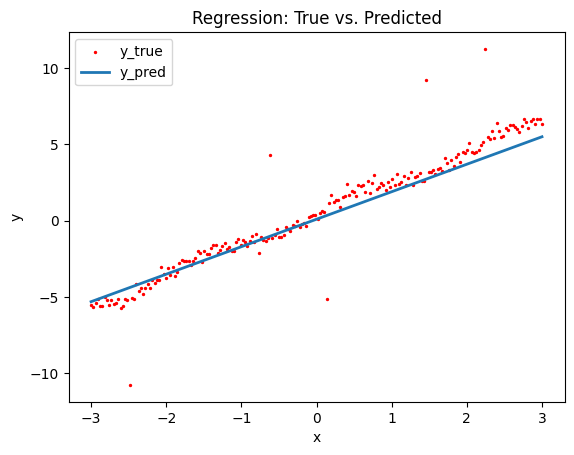

In [10]:

plt.figure()
plt.scatter(df_reg["x"], df_reg["y_true"], label="y_true", c='r', s=2)
plt.plot(df_reg["x"], df_reg["y_pred"], label="y_pred", linewidth=2)
plt.title("Regression: True vs. Predicted")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


### Discussion: Analyze the Regression Plot

Examine the scatter plot (true values) and the line (predicted values) shown **above**.

- Describe how well the fixed linear predictor fits the true data trend.  
- Identify regions where the model **systematically underestimates or overestimates** the target.  
- Comment on the impact of **outliers** on the visual fit and on error metrics (MSE vs. MAE).  
- Based on the visual evidence, propose one or two improvements to reduce error.

Write your interpretation in your own words below.


### <font color='green'>**Answer of Discussion: Analyze the Regression Plot**</font>

*   In general, `y_pred` has crossed well above `y_true`, which indicates the success of the model.
*   I think the prediction is overestimated at `x < -1.5`. It is also underestimated at `x > 0`.
*   Outliers are red points that are very far from the blue prediction line. They make the fit look much worse than it is.
Also, these values ​​will cause a larger loss in MSE than in MAE. Because suppose if the outlier point is 5 units away from the prediction, the loss in MAE will be 5 and in MSE it will be 25.
*   To improve, we can use a curve and a nonlinear model to better match the data. We can also use a better line to better fit the data.



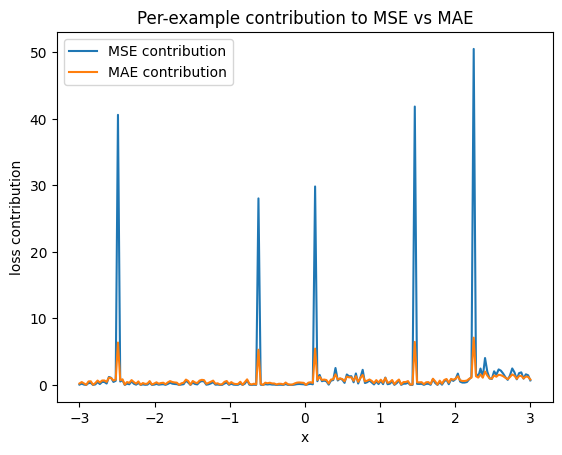

In [11]:

plt.figure()
plt.plot(df_reg["x"], df_reg["mse_contrib"], label="MSE contribution")
plt.plot(df_reg["x"], df_reg["mae_contrib"], label="MAE contribution")
plt.title("Per-example contribution to MSE vs MAE")
plt.xlabel("x")
plt.ylabel("loss contribution")
plt.legend()
plt.show()


### Discussion: Compare Per-Example Error Contributions

Look at the plot **above**, which shows how each data point contributes to the **MSE** and **MAE** losses.

- Describe how the shapes of the MSE and MAE contribution curves differ.  
- Which metric (MSE or MAE) appears more **sensitive to outliers**? Explain why.  
- Identify regions where the error contributions are especially high—what does this tell you about the model’s performance there?  
- Discuss how these patterns might affect how we interpret the overall model quality.

Write your observations and reasoning below.


### <font color='green'>**Answer of Discussion: Compare Per-Example Error Contributions**</font>

* As can be seen, `MSE` has increased sharply in most cases, especially where the `loss contribution` has increased. On the other hand, `MAE` shows a smoother behavior.
* Certainly, `MSE` is more sensitive to outliers. This is because the difference between the true label and the predicted label is squared.
* Obviously, the loss contribution is very high at the 5 points where we manually converted the data into outliers. Here, using MSE will probably severely affect the mean behavior of our model. I think it is better to use MA where we want the outliers to have less impact.
*ّ As mentioned above, MSE will perform poorly here due to outliers. Also, MAE may appear more robust here. This means: if you want a metric that tells you about the typical performance, MAE is more stable. If you want a metric that harshly penalizes any and all large mistakes, MSE is your choice.



#### Hunting for Disagreements (Regression)
We look for **outliers** where MSE contribution is much larger than MAE contribution.


In [12]:

df_reg["ratio_mse_mae"] = df_reg["mse_contrib"] / (df_reg["mae_contrib"] + 1e-12)
# top_outliers = df_reg.sort_values("ratio_mse_mae", ascending=False).head(7)
top_outliers = df_reg.sort_values("ratio_mse_mae", ascending=False).head(5)
top_outliers[["x", "y_true", "y_pred", "residual", "mse_contrib", "mae_contrib", "ratio_mse_mae"]]


,x,y_true,y_pred,residual,mse_contrib,mae_contrib,ratio_mse_mae
174,2.246231,11.251437,4.143216,-7.108221,50.526805,7.108221,7.108221
148,1.462312,9.202203,2.732161,-6.470043,41.861451,6.470043,6.470043
17,-2.487437,-10.750309,-4.377387,6.372922,40.614140,6.372922,6.372922
104,0.135678,-5.118674,0.344221,5.462895,29.843218,5.462895,5.462895
79,-0.618090,4.283513,-1.012563,-5.296076,28.048416,5.296076,5.296076


### Discussion: Interpreting Top Outliers

Review the table **above**, which lists the five samples with the highest **MSE-to-MAE ratio**.

- What does a high `ratio_mse_mae` indicate about a data point’s residual or error magnitude?  
- Compare the `residual`, `mse_contrib`, and `mae_contrib` values—how do they relate for extreme outliers?  
- Do these outliers correspond to visible anomalies in the earlier plots?  
- Explain how such points influence the overall **MSE** much more than the **MAE**, and what that means for evaluating model robustness.

Summarize your insights about how outliers affect both loss metrics.


### <font color='green'>**Answer of Discussion: Interpreting Top Outliers**</font>

* Given that ratio_mse_mae is the result of dividing mse_contrib by mae_contrib, and each is equal to `(residual)^2` and `abs(residual)`, respectively, the result of this division is ultimately equal to `abs(residual)`. As a result, this value refers to the magnitude of a loss contribute.
* Their relationship was also explained in the previous section. Suppose if the residual, which is the difference between y_pred and y_true, is -7, then mae_contrib is equal to the absolute value of -7, that is, 7, and its mse_contrib is equal to 49.
* Yes, all 5 of these anomalies can be found at 5 points that are far from the blue y_pred line.
* As mentioned above, an output for MSE of, for example, 50 and conversely for MAE of 7.1 will ultimately have a much greater impact on the final MSE than the final MAE.
* MAE penalizes outliers linearly. This makes it a robust metric that better reflects the model's typical performance on the majority of the data. MSE penalizes outliers quadratically (squaring the error). This makes it highly sensitive to outliers, as a few bad predictions can dominate the entire metric and make the model's overall performance look much worse than it might be for typical data points.


## Part B — Classification: Cross-Entropy vs Hinge

We create both **binary** and **multiclass** classification scenarios with **fixed** scores/probabilities.
- **Cross-Entropy (CE)** expects probabilities (well-calibrated if possible).
- **Hinge** expects **scores** and focuses on **margins**.

**Key contrast:** CE is sensitive to **confidence calibration**, punishing overconfident wrong predictions heavily.  
Hinge focuses on **ordering/margins**; if correct class has sufficient margin, it does not care about exact probability.


In [13]:
# ---------------------------------------------
# Binary classification: construct labels and predicted probabilities/scores
# ---------------------------------------------

# TODO: set the number of binary samples (e.g., 300)
nb = 300

# TODO: generate random 2D input features
# Example: np.random.randn(nb, 2)
xb = np.random.randn(nb, 2)

# TODO: define a fixed weight vector and bias term
w = np.array([1.5, -2.0])
b = 0.5

# TODO: compute raw logits as a linear combination (xb @ w + b)
logits = xb @ w + b

# Compute sigmoid probabilities from logits (leave as-is)
p = 1.0 / (1.0 + np.exp(-logits))  # sigmoid probs

# TODO: create noisy binary labels for realism
# Hint: add Gaussian noise to logits before thresholding > 0
y_bin = (logits + np.random.normal(0.0, 0.5, size=nb) > 0).astype(int)

# Fixed "scores" for hinge (use raw logits as scores)
scores_bin = logits

# Convert binary labels {0,1} → {-1,+1} for hinge loss
y_pm1 = 2 * y_bin - 1


# ---------------------------------------------
# Multiclass: 3 classes with simple linear scores
# ---------------------------------------------

# TODO: set number of multiclass samples (e.g., 240)
nm = 240

# TODO: generate 2D random features for multiclass examples
xm = np.random.randn(nm, 2)

# TODO: define a simple 3×2 weight matrix for 3 linear classifiers
Wm = np.array([
    [1.0, -1.0],  # Class 0 weights
    [-1.0, 1.0],  # Class 1 weights
    [0.5, 0.5]    # Class 2 weights
])

# TODO: compute linear scores for each class (matrix multiply)
# (xm @ Wm.T) -> (240, 2) @ (2, 3) -> (240, 3) scores
Sm = xm @ Wm.T

# TODO: generate noisy multiclass labels based on scores
# Hint: add noise before taking argmax
y_true_mc = np.argmax(Sm + np.random.normal(0.0, 0.5, size=Sm.shape), axis=1)

# Convert class indices to one-hot encoding
Y_onehot = np.eye(3)[y_true_mc]


# ---------------------------------------------
# Convert scores to probabilities via softmax (for CE)
# ---------------------------------------------

def softmax(Z):
    # subtract max per row for numerical stability
    Z = Z - Z.max(axis=1, keepdims=True)
    expZ = np.exp(Z)
    return expZ / expZ.sum(axis=1, keepdims=True)

# TODO: compute softmax probabilities from multiclass scores
Pm = softmax(Sm)


In [14]:
assert xb.shape == (nb, 2)
assert logits.shape == (nb,)
assert 0 <= p.min() and p.max() <= 1
assert set(np.unique(y_bin)).issubset({0, 1})
assert scores_bin.shape == (nb,)
assert set(np.unique(y_pm1)).issubset({-1, 1})

assert xm.shape == (nm, 2)
assert Sm.shape == (nm, 3)
assert Y_onehot.shape == (nm, 3)
assert np.allclose(Pm.sum(axis=1), 1, atol=1e-8)


In [20]:
# -----------------------------
# Binary metrics
# -----------------------------

# TODO: compute binary cross-entropy using your function on (y_bin, p)
bce_val = binary_cross_entropy(y_bin, p)

# TODO: compute binary hinge loss using labels in {-1,+1} and raw scores
hinge_bin_val = binary_hinge(y_pm1, scores_bin)

# Keep printing (low educational value → no TODO)
print(f"Binary: Cross-Entropy = {bce_val:.4f} | Hinge = {hinge_bin_val:.4f}")

# -----------------------------
# Per-example contributions (binary)
# -----------------------------
# TODO: per-sample BCE contribution:
#  -y*log(clip(p)) - (1-y)*log(clip(1-p))  with clipping to [1e-12, 1-1e-12]
eps_b = 1e-12
p_clipped = np.clip(p, eps_b, 1 - eps_b)
bce_contrib = - (y_bin * np.log(p_clipped) + (1 - y_bin) * np.log(1 - p_clipped))

# TODO: per-sample binary hinge contribution: max(0, 1 - y_pm1 * score)
hinge_contrib = np.maximum(0, 1 - y_pm1 * scores_bin)

# Keep DataFrame construction (mapping columns) as-is
df_bin = pd.DataFrame({
    "y": y_bin,
    "p": p,
    "score": scores_bin,
    "bce": bce_contrib,
    "hinge": hinge_contrib
})

# -----------------------------
# Multiclass metrics
# -----------------------------

# TODO: compute multiclass cross-entropy using one-hot Y and probs Pm
ce_mc_val = multiclass_cross_entropy(Y_onehot, Pm)

# TODO: compute multiclass hinge (Crammer–Singer) on (Y_onehot, Sm) with delta=1.0
hinge_mc_val = multiclass_hinge(Y_onehot, Sm, delta=1.0)

# Keep printing (no TODO)
print(f"Multiclass: Cross-Entropy = {ce_mc_val:.4f} | Hinge = {hinge_mc_val:.4f}")

# -----------------------------
# Per-example CE and hinge (multiclass)
# -----------------------------
eps = 1e-12

# TODO: get true class index per row from one-hot Y
true_idx = np.argmax(Y_onehot, axis=1)

# TODO: per-sample multiclass CE: -log(clip(Pm[range(n), true_idx], eps, 1-eps))
nm_samples = Pm.shape[0]
p_true_class = Pm[np.arange(nm_samples), true_idx]
ce_mc_contrib = -np.log(np.clip(p_true_class, eps, 1 - eps))

# For multiclass hinge per-example (Crammer–Singer sum of margins)
per_ex_hinge_mc = []
for i in range(len(Sm)):
    yi = true_idx[i]
    # TODO: compute margins: 1 - S[i, yi] + S[i, :]
    margin = 1.0 - Sm[i, yi] + Sm[i, :]
    # set correct-class margin to 0 and sum positive parts
    margin[yi] = 0.0
    per_ex_hinge_mc.append(np.maximum(0.0, margin).sum())

# Keep DataFrame construction (output packaging) as-is
df_mc = pd.DataFrame({
    "y": true_idx,
    "p_true": Pm[np.arange(len(Pm)), true_idx],
    "score_true": Sm[np.arange(len(Sm)), true_idx],
    "ce": ce_mc_contrib,
    "hinge": per_ex_hinge_mc
})

# Keep preview (display) as-is
df_bin.head(), df_mc.head()


Binary: Cross-Entropy = 0.2347 | Hinge = 0.1865
Multiclass: Cross-Entropy = 0.4897 | Hinge = 0.4581


(   y         p     score       bce     hinge
 0  1  0.792015  1.337113  0.233175  0.000000
 1  0  0.020841 -3.849749  0.021062  0.000000
 2  0  0.320532 -0.751329  0.386445  0.248671
 3  1  0.917763  2.412335  0.085816  0.000000
 4  0  0.099785 -2.199614  0.105122  0.000000,
    y    p_true  score_true        ce     hinge
 0  0  0.621411    0.993497  0.475762  0.249505
 1  1  0.541123    1.192920  0.614109  0.720282
 2  0  0.504336    0.201025  0.684513  0.597950
 3  2  0.463708    0.575121  0.768501  0.849758
 4  0  0.356556    0.459044  1.031265  1.422183)

In [21]:
# ================== TEST CELL (sanity & consistency checks) ==================
import unittest
import numpy as np
import pandas as pd

class TestMetricsCell(unittest.TestCase):
    @classmethod
    def setUpClass(cls):
        # Check that all required variables exist
        needed = [
            "y_bin", "p", "scores_bin", "y_pm1",
            "bce_val", "hinge_bin_val", "bce_contrib", "hinge_contrib", "df_bin",
            "Y_onehot", "Sm", "Pm",
            "ce_mc_val", "hinge_mc_val", "true_idx", "ce_mc_contrib", "per_ex_hinge_mc", "df_mc"
        ]
        missing = [n for n in needed if n not in globals()]
        if missing:
            raise unittest.SkipTest(f"Missing variables from the metrics cell: {missing}")

    # ---------- Binary ----------
    def test_binary_shapes_and_ranges(self):
        self.assertEqual(y_bin.ndim, 1)
        self.assertEqual(p.ndim, 1)
        self.assertEqual(scores_bin.ndim, 1)
        self.assertEqual(y_pm1.ndim, 1)

        n = len(y_bin)
        self.assertEqual(len(p), n)
        self.assertEqual(len(scores_bin), n)
        self.assertEqual(len(y_pm1), n)

        # y_bin in {0,1}, y_pm1 in {-1,+1}, p in [0,1]
        self.assertTrue(set(np.unique(y_bin)).issubset({0, 1}))
        self.assertTrue(set(np.unique(y_pm1)).issubset({-1, 1}))
        self.assertGreaterEqual(p.min(), 0.0)
        self.assertLessEqual(p.max(), 1.0)

    def test_binary_contribs_and_losses(self):
        # Length consistency
        self.assertEqual(len(bce_contrib), len(y_bin))
        self.assertEqual(len(hinge_contrib), len(y_bin))

        # Non-negativity
        self.assertTrue(np.all(bce_contrib >= 0.0))
        self.assertTrue(np.all(hinge_contrib >= 0.0))

        # Mean of contributions equals total loss
        self.assertAlmostEqual(float(np.mean(bce_contrib)), float(bce_val), places=12)
        self.assertAlmostEqual(float(np.mean(hinge_contrib)), float(hinge_bin_val), places=12)

        # Finite values
        self.assertTrue(np.isfinite(bce_val))
        self.assertTrue(np.isfinite(hinge_bin_val))
        self.assertTrue(np.all(np.isfinite(bce_contrib)))
        self.assertTrue(np.all(np.isfinite(hinge_contrib)))

    def test_df_bin_schema(self):
        self.assertIsInstance(df_bin, pd.DataFrame)
        for col in ["y", "p", "score", "bce", "hinge"]:
            self.assertIn(col, df_bin.columns)
        self.assertEqual(len(df_bin), len(y_bin))

    # ---------- Multiclass ----------
    def test_multiclass_shapes_and_probs(self):
        nm, C = Y_onehot.shape
        self.assertEqual(C, 3)
        self.assertEqual(Sm.shape, (nm, C))
        self.assertEqual(Pm.shape, (nm, C))

        # One-hot validity and row sums
        self.assertTrue(np.allclose(Y_onehot.sum(axis=1), 1.0))
        self.assertTrue(set(np.unique(Y_onehot)).issubset({0.0, 1.0}))

        # Softmax validity
        self.assertTrue(np.allclose(Pm.sum(axis=1), 1.0, atol=1e-10))
        self.assertGreaterEqual(Pm.min(), 0.0)
        self.assertLessEqual(Pm.max(), 1.0)

    def test_multiclass_indices_and_vectors(self):
        # true_idx must equal argmax of Y_onehot
        self.assertTrue(np.array_equal(true_idx, np.argmax(Y_onehot, axis=1)))

        # Check that p_true and score_true correspond to correct indices
        idx = np.arange(len(Pm))
        p_true = Pm[idx, true_idx]
        score_true = Sm[idx, true_idx]

        # df_mc column schema
        self.assertIsInstance(df_mc, pd.DataFrame)
        for col in ["y", "p_true", "score_true", "ce", "hinge"]:
            self.assertIn(col, df_mc.columns)
        self.assertEqual(len(df_mc), len(true_idx))

        # Match values
        np.testing.assert_allclose(df_mc["p_true"].values, p_true, rtol=0, atol=0)
        np.testing.assert_allclose(df_mc["score_true"].values, score_true, rtol=0, atol=0)

    def test_multiclass_contribs_and_losses(self):
        # Lengths
        self.assertEqual(len(ce_mc_contrib), len(true_idx))
        self.assertEqual(len(per_ex_hinge_mc), len(true_idx))

        # Non-negativity
        self.assertTrue(np.all(ce_mc_contrib >= 0.0))
        self.assertTrue(np.all(np.asarray(per_ex_hinge_mc) >= 0.0))

        # Mean of contributions equals total loss
        self.assertAlmostEqual(float(np.mean(ce_mc_contrib)), float(ce_mc_val), places=12)
        self.assertAlmostEqual(float(np.mean(per_ex_hinge_mc)), float(hinge_mc_val), places=12)

        # Finite values
        self.assertTrue(np.isfinite(ce_mc_val))
        self.assertTrue(np.isfinite(hinge_mc_val))
        self.assertTrue(np.all(np.isfinite(ce_mc_contrib)))
        self.assertTrue(np.all(np.isfinite(per_ex_hinge_mc)))

# ---- Run tests in-notebook ----
runner = unittest.TextTestRunner(verbosity=2)
suite = unittest.defaultTestLoader.loadTestsFromTestCase(TestMetricsCell)
result = runner.run(suite)
print("\nAll tests passed." if result.wasSuccessful() else "\nSome tests failed.")
# ===============================================================================


test_binary_contribs_and_losses (__main__.TestMetricsCell.test_binary_contribs_and_losses) ... ok
test_binary_shapes_and_ranges (__main__.TestMetricsCell.test_binary_shapes_and_ranges) ... ok
test_df_bin_schema (__main__.TestMetricsCell.test_df_bin_schema) ... ok
test_multiclass_contribs_and_losses (__main__.TestMetricsCell.test_multiclass_contribs_and_losses) ... ok
test_multiclass_indices_and_vectors (__main__.TestMetricsCell.test_multiclass_indices_and_vectors) ... ok
test_multiclass_shapes_and_probs (__main__.TestMetricsCell.test_multiclass_shapes_and_probs) ... ok

----------------------------------------------------------------------
Ran 6 tests in 0.020s

OK



All tests passed.


In [17]:

plt.figure()
plt.scatter(df_bin["p"], df_bin["bce"])
plt.title("Binary CE vs. predicted probability (true class)")
plt.xlabel("p (for y=1)")
plt.ylabel("CE contribution")
plt.show()


NameError: name 'df_bin' is not defined

<Figure size 640x480 with 0 Axes>

### Discussion: Interpreting Binary CE vs. Predicted Probability

Examine the plot **above**, which shows the **per-example Cross-Entropy loss** versus the model’s predicted probability for the true class (`p` for `y=1`).

- Explain why CE is **small** when the model predicts the true class with **high confidence** (p close to 1), but **grows rapidly** as p approaches 0.  
- Analyze the **curvature** of the relationship — what does it reveal about CE’s sensitivity to **high-confidence mistakes**?  
- Do you observe any regions suggesting the model might be **miscalibrated** (for example, large CE at mid-range probabilities)?  
- How might **probability clipping** near 0 or 1 affect the observed pattern?  
- Based on your observations, suggest ways to improve model behavior (e.g., **probability calibration**, **threshold tuning**, or **regularization**).

Write your analysis and reasoning below.


In [ ]:

margin = (2*df_bin["y"]-1) * df_bin["score"]
plt.figure()
plt.scatter(margin, df_bin["hinge"])
plt.title("Binary Hinge vs. margin (y * score)")
plt.xlabel("margin")
plt.ylabel("Hinge contribution")
plt.show()


### Discussion: Interpreting Binary Hinge Loss vs. Margin

Look at the plot **above**, which shows each example’s **hinge loss contribution** as a function of its **margin** (`y * score`).

- Describe how hinge loss behaves when the margin is **greater than 1**, **around 1**, and **below 0**.  
- Explain why points with **large positive margins** have zero loss, while those with **negative margins** contribute heavily.  
- Discuss how the hinge loss encourages a **margin of at least 1** between classes and what this means for model confidence.  
- Identify the region where most samples lie—does this suggest a well-separated or poorly-separated dataset?  
- Compare the hinge loss’s treatment of misclassified examples to that of cross-entropy (which one penalizes them more sharply?).

Write your interpretation and insights below.


In [ ]:

plt.figure()
plt.scatter(df_mc["p_true"], df_mc["ce"])
plt.title("Multiclass CE vs. p_true")
plt.xlabel("p_true (softmax prob of true class)")
plt.ylabel("CE contribution")
plt.show()


### Discussion: Interpreting Multiclass CE vs. True-Class Probability

Examine the plot **above**, which shows the **per-example Cross-Entropy loss** for multiclass classification as a function of the model’s predicted probability for the **true class** (`p_true`).

- Describe how CE changes as `p_true` increases — why does the loss drop sharply for confident predictions?  
- Explain what the shape of the curve reveals about CE’s sensitivity to **low-confidence predictions** and **misclassifications**.  
- Identify any regions where the loss values are unexpectedly high or low — what might these indicate about the model’s **confidence calibration**?  
- Discuss how this relationship differs from the binary CE plot and what additional challenges multiclass settings introduce.  
- Suggest ways to improve model performance or calibration based on what you observe (e.g., softmax temperature scaling, data balancing).

Write your observations and explanation below.


In [ ]:

max_other = []
for i in range(len(Sm)):
    yi = df_mc["y"].iloc[i]
    others = np.delete(Sm[i, :], yi)
    max_other.append(np.max(others))
gap = df_mc["score_true"].values - np.array(max_other)

plt.figure()
plt.scatter(gap, df_mc["hinge"])
plt.title("Multiclass Hinge vs. score gap (true - best other)")
plt.xlabel("score gap")
plt.ylabel("Hinge contribution")
plt.show()


### Discussion: Interpreting Multiclass Hinge Loss vs. Score Gap

Review the plot **above**, which shows the **multiclass hinge loss contribution** for each example as a function of the **score gap** — the difference between the model’s score for the true class and the highest score among the other classes.

- Explain how the hinge loss behaves as the score gap increases — why does the loss reach **zero** once the true class score is sufficiently higher than others?  
- Describe what happens when the score gap is **negative** or close to **zero** — what does this indicate about misclassified or uncertain samples?  
- Discuss how the hinge loss enforces a **margin constraint** between the true and competing classes.  
- Identify whether the dataset appears to have a clear separation between classes or many samples near the margin.  
- Compare this behavior with that of **cross-entropy loss** — which one penalizes close class scores more aggressively?

Write your interpretation and conclusions below.



### Hunting for Disagreements (Classification)
We rank by **difference ratios** to find examples that CE punishes heavily but Hinge does not, and vice versa.


In [18]:

# Binary
ratio_ce_hinge_b = df_bin["bce"] / (df_bin["hinge"] + 1e-12)
ratio_hinge_ce_b = df_bin["hinge"] / (df_bin["bce"] + 1e-12)
print("Binary — CE >> Hinge (top 5):")
display(df_bin.assign(ratio=ratio_ce_hinge_b).sort_values("ratio", ascending=False).head(5))

print("Binary — Hinge >> CE (top 5):")
display(df_bin.assign(ratio=ratio_hinge_ce_b).sort_values("ratio", ascending=False).head(5))

# Multiclass
ratio_ce_hinge_m = df_mc["ce"] / (df_mc["hinge"] + 1e-12)
ratio_hinge_ce_m = df_mc["hinge"] / (df_mc["ce"] + 1e-12)
print("Multiclass — CE >> Hinge (top 5):")
display(df_mc.assign(ratio=ratio_ce_hinge_m).sort_values("ratio", ascending=False).head(5))

print("Multiclass — Hinge >> CE (top 5):")
display(df_mc.assign(ratio=ratio_hinge_ce_m).sort_values("ratio", ascending=False).head(5))


NameError: name 'df_bin' is not defined

### Discussion: Comparing CE and Hinge Loss Dominance

Review the tables **above**, which list the top 5 samples where **Cross-Entropy (CE)** dominates **Hinge loss** and vice versa — for both **binary** and **multiclass** settings.

- Examine cases where **CE >> Hinge**: what characteristics (e.g., probability, margin, or confidence level) might cause CE to assign much higher loss than Hinge?  
- Examine cases where **Hinge >> CE**: what does this reveal about samples with small or negative margins but moderate probabilities?  
- How do these differences reflect the **mathematical nature** of CE (smooth, log-based) versus Hinge (piecewise linear, margin-based)?  
- Compare binary and multiclass results — do they show similar or different behavior patterns?  
- Based on these insights, which loss might be more appropriate under different conditions (e.g., noisy data, separable data, or calibrated probabilities)?

Summarize your interpretation and reasoning below.


## Bring Your Own Predictions — CSV Hooks (TODO)

Replace the synthetic predictions with your own model outputs (**fixed**, no training here).  
Prepare CSV files with the following minimal schemas and update the file paths below.

### Regression CSV
- Columns: `y_true`, `y_pred`

### Binary Classification CSV
- Columns: `y_true` (0/1), `p_pred` (probability for class 1), `score` (optional raw score/logit)

### Multiclass Classification CSV
- Columns: `y_true` (integer class), and `p_c0, p_c1, ..., p_c{C-1}` for class probabilities  
  (optional) `s_c0, s_c1, ..., s_c{C-1}` raw scores for hinge

**TODO:** Uncomment and point to your file paths, then run.


In [ ]:

# === REGRESSION CSV (TODO) ===
# df_reg_csv = pd.read_csv("path/to/your_regression_predictions.csv")
# print(df_reg_csv.head())
# print("MSE:", mse(df_reg_csv["y_true"].values, df_reg_csv["y_pred"].values))
# print("MAE:", mae(df_reg_csv["y_true"].values, df_reg_csv["y_pred"].values))

# === BINARY CLASSIFICATION CSV (TODO) ===
# df_bin_csv = pd.read_csv("path/to/your_binary_predictions.csv")
# print(df_bin_csv.head())
# y_true = df_bin_csv["y_true"].values.astype(int)
# p_pred = df_bin_csv["p_pred"].values.astype(float)
# score  = df_bin_csv["score"].values.astype(float) if "score" in df_bin_csv.columns else np.log(p_pred + 1e-12) - np.log(1 - p_pred + 1e-12)
# print("BCE:", binary_cross_entropy(y_true, p_pred))
# print("Hinge (binary):", binary_hinge(2*y_true-1, score))

# === MULTICLASS CLASSIFICATION CSV (TODO) ===
# df_mc_csv = pd.read_csv("path/to/your_multiclass_predictions.csv")
# print(df_mc_csv.head())
# y_true = df_mc_csv["y_true"].values.astype(int)
# prob_cols = [c for c in df_mc_csv.columns if c.startswith("p_c")]
# P = df_mc_csv[prob_cols].values
# Y = np.eye(P.shape[1])[y_true]
# print("CE (multiclass):", multiclass_cross_entropy(Y, P))
# score_cols = [c for c in df_mc_csv.columns if c.startswith("s_c")]
# if len(score_cols) == P.shape[1]:
#     S = df_mc_csv[score_cols].values
#     print("Hinge (multiclass):", multiclass_hinge(Y, S))



## Design Your Experiments (TODO)

Use the hooks above to design rigorous comparisons. Here are suggested **experiments**:

1. **Outlier Sensitivity (Regression).**  
   - Inject varying magnitudes of outliers and track how MSE vs MAE change.  
   - Plot metric values as a function of outlier magnitude/fraction.

2. **Calibration vs Margin (Binary Classification).**  
   - Construct examples with correct ordering but **overconfident** wrong probabilities.  
   - Show CE rises sharply while Hinge may remain lower if margins are decent.  
   - Conversely, create cases with **good probabilities** but **small margins** and see Hinge stay high.

3. **Class Imbalance (Multiclass).**  
   - Skew class frequencies and observe how CE and Hinge respond.  
   - Report per-class contributions (mean loss per class) to discuss fairness.

4. **Noise Stress-Test.**  
   - Add label noise and study which metric is more stable across noise levels.

5. **Thresholding Analysis (Binary).**  
   - For a fixed probability vector, vary the decision threshold and inspect how loss metrics correlate with accuracy/F1 (as *report-only* statistics).

> **Deliverables:** Tables/plots summarizing each experiment, and 2–3 short **case studies** explaining disagreements. Keep the models/predictions *fixed per experiment* (no retraining).



## Utility: Per-Class Summaries
Convenience helpers to build clean tables for your report.


In [19]:

def per_class_summary(labels: np.ndarray, values: np.ndarray) -> pd.DataFrame:
    labels = np.asarray(labels).astype(int)
    df = pd.DataFrame({"label": labels, "val": values})
    return df.groupby("label")["val"].agg(["count", "mean", "std"]).reset_index()

# Examples:
print("Binary per-class CE:")
display(per_class_summary(df_bin["y"].values, df_bin["bce"].values))

print("Multiclass per-class CE:")
display(per_class_summary(df_mc["y"].values, df_mc["ce"].values))


Binary per-class CE:


NameError: name 'df_bin' is not defined

### Discussion: Per-Class Summary of CE

Review the per-class tables **above**, which report the **count**, **mean**, and **std** of per-example Cross-Entropy (CE) for each label.

- Which classes show the **highest** and **lowest** mean CE? What might this indicate about model difficulty by class?  
- How does **std** differ across classes? Do large standard deviations suggest inconsistent performance or subgroups within a class?  
- Do class **counts** reveal imbalance? If so, how might imbalance be affecting mean CE and your interpretation of fairness?  
- Are there classes where high mean CE aligns with patterns you observed in earlier plots (e.g., low `p_true`, small margins)?  
- Propose at least one action to address any issues you identify (e.g., reweighting, data augmentation, calibration, or threshold tuning).

Write your analysis below.



## Summary & Reflection

- **MSE vs MAE:** MSE amplifies large residuals (outliers), MAE is more robust. Choose based on your tolerance to outliers.  
- **Cross-Entropy vs Hinge:** CE cares about **calibrated probabilities** and is unforgiving of overconfident mistakes; Hinge cares about **margins** and ignores probability calibration once margin is large enough.  
- **Disagreements are informative:** Inspecting where metrics disagree often reveals data issues (outliers, label noise) or model behavior (overconfidence, low margins).

**Short write-up (required):**  
Add 2–3 paragraphs interpreting your findings on your chosen dataset, highlighting at least two disagreeing examples. (Replace this text in your submission.)
